# Spectral analysis of 5000 movies network
### by Macko Vladimir, Novakovic Milica, Pavué Clément, Roussaky Mehdi

## Goal of the Project:


The aim is to create a graph in which nodes represent movies and edges represent similarity between the movies they are connecting. Described graph represents a network of movies and their relations using descriptions of 5000 selected movies leading to movie genre classification, suggestion of the best movie to represent the genre and quantifying how much $mainstream$ the movie is. 

## Data Acquisition:

The starting point is TMDB 5000 Movie Dataset, available at Kaggle web page, contains information about 5000 selected movies provided by users and reviewers from The Movie Database (TMDb). Namely,
each of the selected movies has the following attributes: budget, genres, homepage, id,
keywords, original language, original title, overview, popularity, production companies,
production coutries, release data, revenue and personnel aspects of cast and crew members listing their names, genders and role or contribution to the movie production and
other details. The majority of the data is in the text format encoded in JSON structure. 

Since the files in JSON format are not practical for manipulations, one single dataset is prapered in Pandas data-frame structure from 2 original JSON datafiles. During this preparation the data is cleaned, e.g. unuseful collumns are removed and corrupted lines (which have missing movie title or other issues are removed), it was examined that there are no duplicates in the produced dataset.

In [1]:
#classical inputs
import sys, os, pathlib

import matplotlib.pyplot as plt
from sklearn import preprocessing, decomposition
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

#setting the path to folder with modules
sys.path.insert(0, str(pathlib.Path(os.getcwd()).parents[0] / 'python'))
from Load_Datasets import *

#Loading information about movies (transforming JSON files into pandas frame)
FileAddress_movies ="../Datasets/tmdb_5000_movies.csv"
FileAddress_credits="../Datasets/tmdb_5000_credits.csv"

Custom made function $Load Datasets$ in order to convert JSON database from two input files to one single Pandas dataframe which contains movies as lines and movie attributes as columns. For more details refer to function $Load Datasets$ [implementation](https://github.com/ryancier/FinalProjectNTDS2017/blob/master/python/Load_Datasets.py)


After the first examination of the data, the following movie attributes are considered no usefull for further analysis movie id, production status (since the vast majority of movies are are released and those which are not released have no actors published and hence are subsequently removed) and homepage (since homepage does address does not contains only information which is in the movie title)

In [2]:
#Loading information about movies
Movies = Load_Datasets(FileAddress_movies,FileAddress_credits)

Drops = ['homepage','status','id']
for drop in Drops:
    Movies = Movies.drop(drop, 1)

#pandas entries contain string arrays from which can be easily converted to lists using string.split(",")
#new datafile is generated
Movies.to_csv("../../Datasets/Transformed.csv")

Final categoties are below: There is a list of actors for each movies and list of their genders. Also, there is a list of crew names and their job and departement and other movie markers such as movie popularity, revenue, etc.

In [3]:
list(Movies)

['budget',
 'genres',
 'keywords',
 'original_language',
 'original_title',
 'overview',
 'popularity',
 'production_companies',
 'production_countries',
 'release_date',
 'revenue',
 'runtime',
 'spoken_languages',
 'tagline',
 'vote_average',
 'vote_count',
 'genres_id',
 'keywords_id',
 'production_companies_id',
 'actors',
 'actors_id',
 'actor_gender',
 'crew_names',
 'crew_names_id',
 'crew_jobs',
 'crew_departments',
 'primary_genre',
 'primary_production_company',
 'prime_actors',
 'prime_crew_names',
 'prime_keywords']

In [4]:
#Example 
print("Avatar 1st crew member is "+Movies['crew_names']['Avatar'].split(",")[0]
      +", he works at departement "+Movies['crew_departments']['Avatar'].split(",")[0]
      +", and his job is "+Movies['crew_jobs']['Avatar'].split(",")[0])

Avatar 1st crew member is Stephen E. Rivkin, he works at departement Editing, and his job is Editor


After removal of all the movies which are incomplete or not fully released, there are 4809 remaining movie entries in the dataset

In [5]:
len(Movies)

4809

## Data Exploration

Here we will present distributions of different features of the movies, i.e. movies budget, revenue, average vote, vote counts, popularity, number of actors and number of movies cast.

Dataset preview:

In [6]:
Movies.head(3)

,budget,genres,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,...,genres_id,keywords_id,production_companies_id,actors,actors_id,actor_gender,crew_names,crew_names_id,crew_jobs,crew_departments
title,,,,,,,,,,,,,,,,,,,,,
#Horror,1500000,"Drama,Mystery,Horror,Thriller",,de,#Horror,"Inspired by actual events, a group of 12 year ...",2.815228,"AST Studios,Lowland Pictures",United States of America,2015-11-20,...,"18,9648,27,53",,"75277,75278","Taryn Manning,Natasha Lyonne,Chloë Sevigny,Bal...","343,10871,2838,9296,16327,210573,180425,110233...","1,1,1,2,2,1,0,0,1","Tara Subkoff,Tara Subkoff,Tara Subkoff,Jason L...","61111,61111,61111,1382445,1382446,1382448","Screenplay,Director,Producer,Producer,Producer...","Writing,Directing,Production,Production,Produc..."
(500) Days of Summer,7500000,"Comedy,Drama,Romance","date,sex,jealousy,fight,architect,gallery,inte...",en,(500) Days of Summer,"Tom (Joseph Gordon-Levitt), greeting-card writ...",45.610993,"Fox Searchlight Pictures,Watermark,Dune Entert...",United States of America,2009-07-17,...,"35,18,10749","248,572,931,1721,2301,2861,4434,5923,8508,9673...","43,4364,6332","Joseph Gordon-Levitt,Zooey Deschanel,Chloë Gra...","24045,11664,56734,5375,5661,9048,56358,96624,9...","2,1,1,2,2,2,1,1,1,2,2,1,1,0,2,1,0,0,1,0,0,2,0","Mychael Danna,Hope Hanafin,Steven J. Wolfe,Mas...","5359,16469,22433,52446,52449,53648,54050,66519...","Original Music Composer,Costume Design,Produce...","Sound,Costume & Make-Up,Production,Production,..."
10 Cloverfield Lane,15000000,"Thriller,Science Fiction,Drama","kidnapping,bunker,paranoia,basement,survivalis...",en,10 Cloverfield Lane,"After a car accident, Michelle awakens to find...",53.698683,"Paramount Pictures,Bad Robot,Spectrum Effects",United States of America,2016-03-10,...,"53,878,18","1930,2321,2340,9866,10833,12332,13063,15381","4,11461,78177","Mary Elizabeth Winstead,John Goodman,John Gall...","17628,1230,17487,51329,60881,1354257,8269,1413...","1,2,2,2,2,0,1,0,2,0","Monika Mikkelsen,J.J. Abrams,Matthew W. Mungle...","2325,15344,23788,69506,59811,66491,92336,13649...","Casting,Producer,Makeup Effects,Director of Ph...","Production,Production,Crew,Camera,Sound,Art,Cr..."


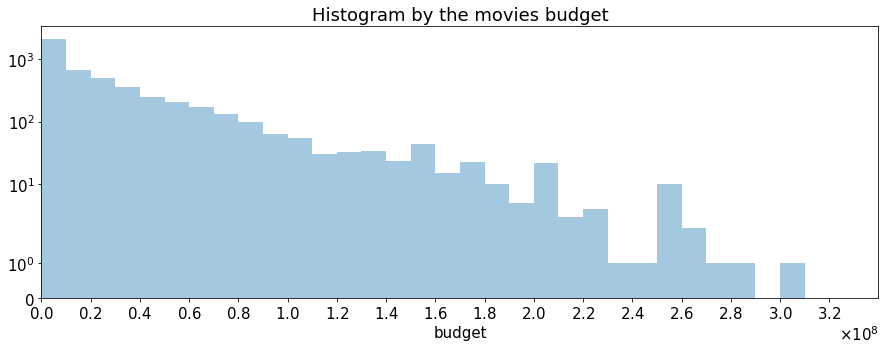

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
% matplotlib inline
fontsizes = 15
matplotlib.rcParams.update({'font.size': fontsizes})
fig, axes = plt.subplots(figsize=(15, 5))

# Budget is plotted in log scale on y axis
axes.set(yscale="symlog")

# Here we will set appropriate range of values x-axis and binsize so that ticks on x-coordinate correspond to 
# the end of every second bin
# for every other data i.e. reveunue, average vote, etc. the values of bin_size will be specific
# hence this procedure will be conducted for each column of interest

bin_size = 0.1*1e8
bins_hist = np.arange(min(Movies["budget"]), max(Movies["budget"]), bin_size)
g = sns.distplot(Movies['budget'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0*1e8,3.4*1e8)
ticks = np.arange(0*1e8,3.4*1e8,0.2*1e8)
axes.set_xticks(ticks)
g.set(title='Histogram by the movies budget')
g.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plt.show()

Here is presented logarithmic vs. linear scale distribution of movies budget, due to tailed nature of distribution. We can notice there is a lot of movies with low budget less than $10^{8}$, and a small number of movies with budget grater than  $3*10^{8}$

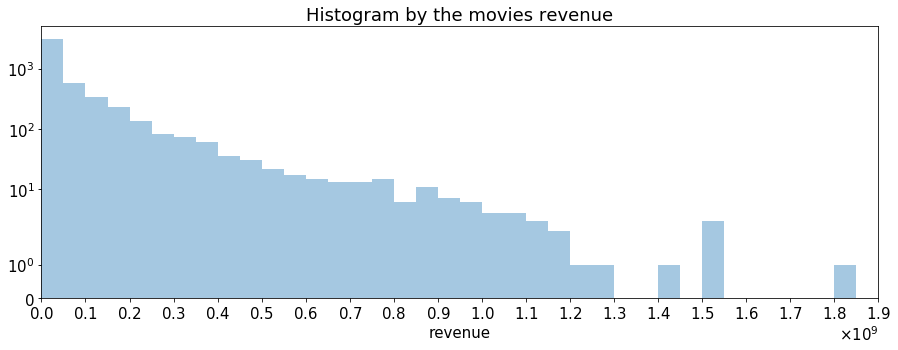

In [8]:
fig, axes = plt.subplots(figsize=(15, 5))
# Revenue is plotted in log scale on y axis
axes.set( yscale="symlog")

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 0.05*1e9
bins_hist = np.arange(min(Movies["revenue"]), max(Movies["revenue"]), bin_size)
g = sns.distplot(Movies['revenue'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0,1.9*1e9)
g.set(title='Histogram by the movies revenue')
ticks = np.arange(0*1e9,2*1e9,0.1*1e9)
axes.set_xticks(ticks)
g.xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter(useMathText=True, useOffset=False))
plt.show()

The presented distribution has been plotted in logarithmic vs. linear scale, due to tailed nature of data. The revenue of the movie has usually value less than $10^{9}$, the its distribution is haevily tailed.The range of movies revenue is from $(0, 2.8*10^{9})$

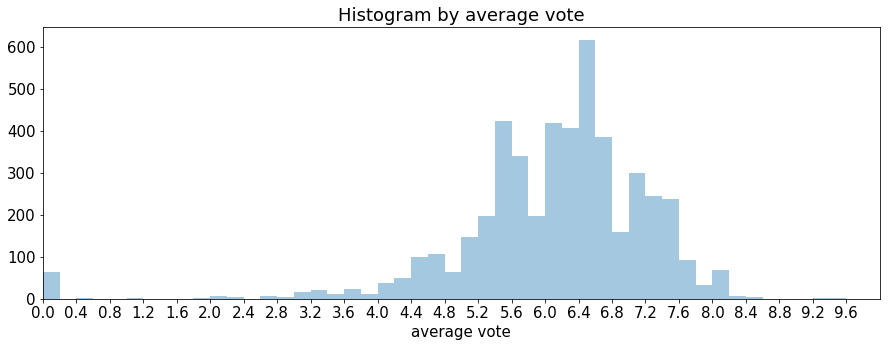

In [9]:
fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 0.2
bins_hist = np.arange(min(Movies["vote_average"]), max(Movies["vote_average"]), bin_size)
g = sns.distplot(Movies['vote_average'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0,10)
ticks = np.arange(0,10,0.4)
axes.set_xticks(ticks)
g.set(title='Histogram by average vote', xlabel = "average vote")
plt.show()

Movies can receive a vote in range 0-10 from user. Average vote is calculated as mean value of all existing votes for that movie. The most frequent vote is less near 6.5. Also, one could notice there is a lot of average_votes in intervals 5.4-5.8, 6.0-6.8, and 7.0-7.6 compared to their "neighbourhood" intervals. There is a lot of movies with vote 0, so it could mean that 0 is written for movies who has not given the vote

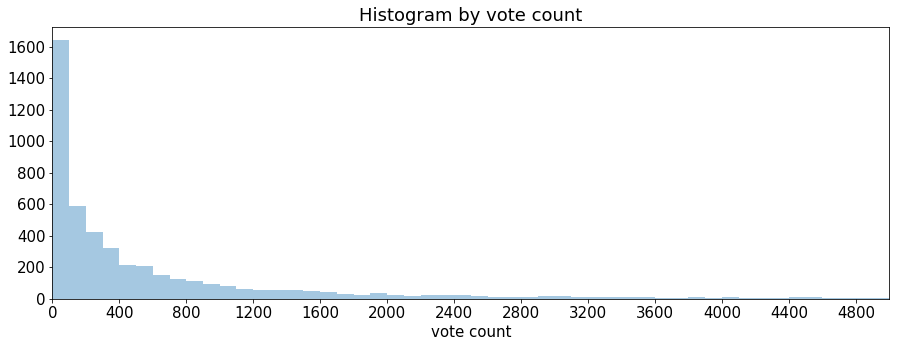

In [10]:
fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every fourth bin

bin_size = 100
bins_hist = np.arange(min(Movies["vote_count"]), max(Movies["vote_count"]), bin_size)
g = sns.distplot(Movies['vote_count'], bins = bins_hist, kde=False, rug=False)
plt.xlim(0,5000)
ticks = np.arange(0,5000, 400)
axes.set_xticks(ticks)
g.set(title='Histogram by vote count', xlabel = "vote count")
plt.show()

Distribution of vote count is tailed, usually movies has less than 400 votes, and vast majority has less than 2000 votes

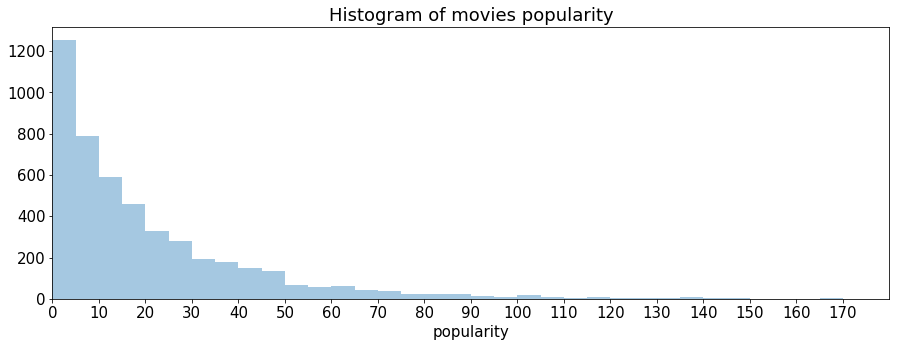

In [11]:
fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 5
bins_hist = np.arange(min(Movies["popularity"]), max(Movies["popularity"]), bin_size)
g = sns.distplot(Movies['popularity'], bins = bins_hist, kde=False, rug=False )
plt.xlim(0,180)
ticks = np.arange(0,180,10)
axes.set_xticks(ticks)
g.set(title='Histogram of movies popularity')
plt.show()

A lot of movies has a low popularity, it seems like 0 is popularity when movie has not given the popularity data 

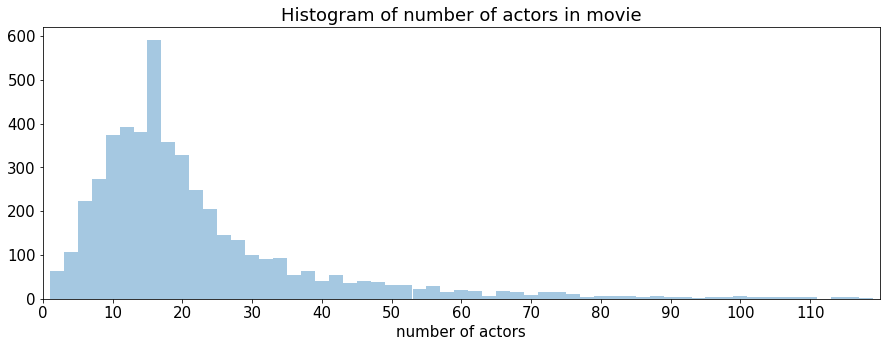

In [12]:
num_of_elements = lambda x: len(x.split(","))
num_of_actors 

fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every second bin

bin_size = 2
bins_hist = np.arange(min(num_of_actors), max(num_of_actors), bin_size)
g = sns.distplot(num_of_actors, bins=bins_hist, kde=False, rug=False )
plt.xlim(0,120)
ticks = np.arange(0,120,10)
axes.set_xticks(ticks)
g.set(title='Histogram of number of actors in movie', xlabel = "number of actors")
plt.show()

The mode of actors in the movie is 15 or 16, and it does not fit very well in the rest of the distribution. Just a couple of movies has more then 100 actors

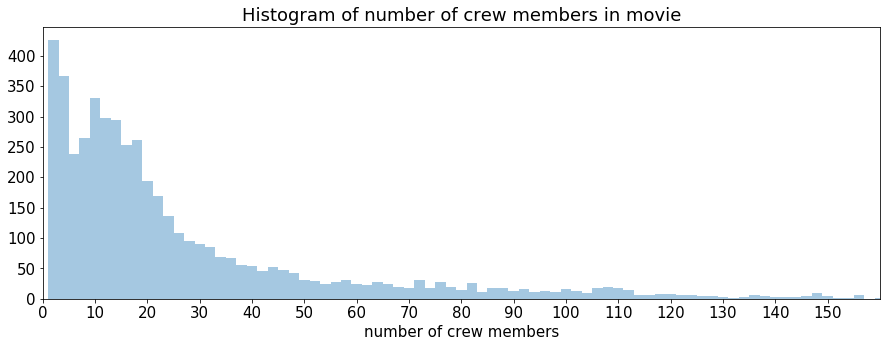

In [13]:
num_of_crew = Movies["crew_names_id"].apply(num_of_elements)

fig, axes = plt.subplots(figsize=(15, 5))

# Here we will set appropriate range of values on x-axis and binsize so that ticks on x-coordinate correspond to
# the end of every fifth bin

bin_size = 2
bins_hist = np.arange(min(num_of_actors), max(num_of_actors), bin_size)
g = sns.distplot(num_of_crew, bins = bins_hist, kde=False, rug=False )
plt.xlim(0,160)
ticks = np.arange(0,160,10)
axes.set_xticks(ticks)
g.set(title='Histogram of number of crew members in movie', xlabel = "number of crew members")
plt.show()

The number of crew members is most times less than 50, and there is some movie up to 200 crew members. It is more frequent to have cast larger than 50 crew members, than 50 actors which is expected

Now, we will find the most frequent keywords, crew members, production companies, actors and genres:

Here is the function which we use for representing most frequent how_much (i.e. 10) production companies and actors. What we are looking for we will call the item in the comments and code i.e. items are production companies or actors

In [14]:
def most_freq_items_with_id(how_much, col, col_id):
    # how_much: how_much top frequent items fo we search for, type:int
    # col: name of the column in Movies dataframe which has also corresponding id column i.e. "production_companies", type:string
    # col_id: name of the column in Movies dataframe with ids
    
    # Due to the fact that the id's as integers are more reliable data than the string type of data
    # we will find most frequent item's ids, and then look for the items name given in the column Movies[col]
    # of course we assume that we have obtained correct match between (items name, items id)

    # Here we will find the number of occurency of each items_id in database,
    # and store it in dictionary items_id_dict in pairs (items_id(type:int):items_name(type:string))
    # we will store in dictionary freq_items_ids in pairs (items_id(type:int):number_of_occurency(type:int))

    items_id_dict = {}
    freq_items_ids = {}
    
    for i in range(len(Movies)):
        for j in range(len(Movies.iloc[i][col_id].split(","))):
            if (len(Movies.iloc[i][col_id].split(",")[j])>0):
                items_id_int_key = int(Movies.iloc[i][col_id].split(",")[j])
                freq_items_ids[items_id_int_key] = freq_items_ids.get(items_id_int_key, 0) + 1
                items_id_dict[items_id_int_key] = Movies.iloc[i][col].split(",")[j]
    
    # Here we will find most how_much frequent items names
    # We will "sort" the dictionary of occurency by values, retrieve the ids of most frequent ones
    # and find corresponding names and store in most_freq_items
 
    how_much_items = how_much; 
    most_freq_ids = sorted(freq_items_ids, key=freq_items_ids.get)[-how_much_items:] #list
    most_freq_items = [items_id_dict[key]  for key in most_freq_ids]

    fig, ax = plt.subplots(figsize=(15,5))

    # in freq_items_plot is stored number_of-occurency in dataset of most frequent items
    freq_items_plot = [freq_items_ids[most_freq_ids[how_much_items-i-1]] for i in range(how_much_items)]
    plt.bar(range(how_much_items), freq_items_plot)
    string_title = col.replace("_"," ")
    plt.title("Most {} frequent ".format(how_much_items)+string_title)
    plt.xticks(range(how_much_items),(most_freq_items[::-1]), rotation=45, rotation_mode="anchor", ha="right")
    for i in ax.patches:
        ax.text(i.get_x()+.1, i.get_height(),str(round((i.get_height()))), fontsize=15, color='black')
    plt.show()

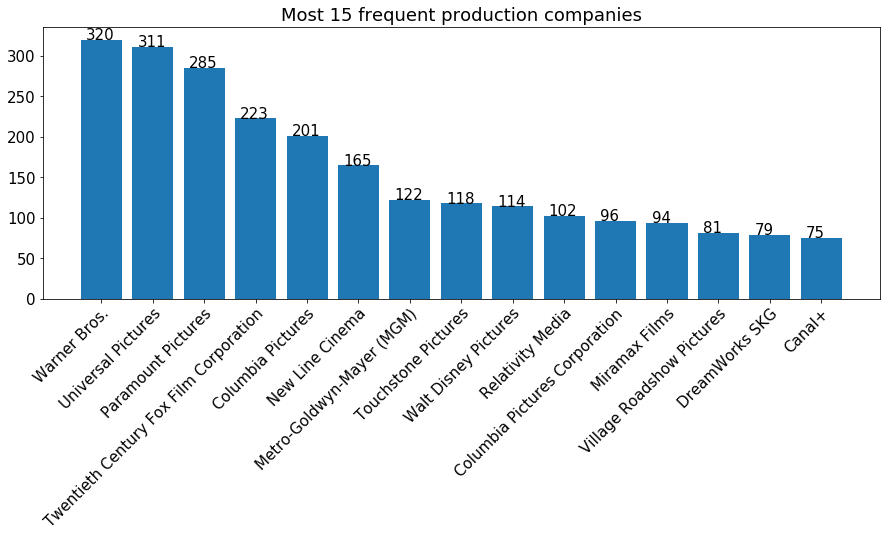

In [15]:
how_much_production = 15
column = "production_companies"
column_id = "production_companies_id"
most_freq_items_with_id(how_much_production, column, column_id)

Here are shown 15 most frequent production companies. The first three companies has made around 300 movies each which is nearly 20% of all the movies. The next three companies has made more than 150 movies each, and they are followed by the rest top companies who made 100 movies on average.

It seems like we have dominant production companies: Warner Bros. Universal Pictures and Paramount Pictures

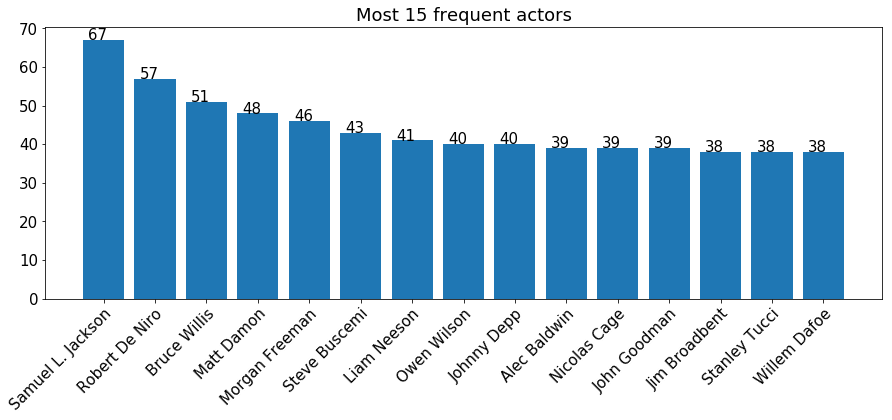

In [16]:
how_much_actors = 15
column = "actors"
column_id = "actors_id"
most_freq_items_with_id(how_much_production, column, column_id)

Here are shown 15 most frequent actors. All of them has shown up in more than 40 movies. The most frequent actor Samuel L. Jaskson has been in nearly 70 movies, after the distribution of the top actors slowly decrease

Here is the function which we use for representing most frequent how_much (i.e. 10) keywords, crew and genres. What we are looking for we will call the item in the comments and code (i.e. item is keyword crew_name or genre)

In [17]:
def most_freq_items(how_much, col):
    # how_much: how_much top frequent items fo we search for, type:int
    # col: name of the column in Movies dataframe i.e. "keywords", type:string
    # string_title: string for title "Most how_much frequent"+string_title i.e. string_title="keywords", type:string
    
    # This function will be used to find most frequent keywords, crew_names and genres
    # Here we will find the number of occurency of each keyword in database,
    # and store it in dictionary items_dict in pairs (item(type:str):number_of_occurency(type:int))
    items_dict = {}

    for i in range(len(Movies)):
        if(len(Movies.iloc[i][col])>0):
            for j in range(len(Movies.iloc[i][col].split(","))):
                if (len(Movies.iloc[i][col].split(","))>0):
                    item = Movies.iloc[i][col].split(",")[j]
                    items_dict[item] = items_dict.get(item, 0) + 1
    # Here we will find most how_much_items frequent keywords
    # We will "sort" the dictionary by values, retrieve the ids, and find the most frequent items from original dictionary
    
    how_much_items = how_much
    most_freq_items = sorted(items_dict, key=items_dict.get)[-how_much_items:]
    
    fig, ax = plt.subplots(figsize=(15,5))
    
    freq_items_plot = [items_dict[most_freq_items[len(most_freq_items)-1-i]] for i in range(how_much_items)]
    plt.bar(range(how_much_items), freq_items_plot)
    string_title = col.replace("_"," ")
    plt.title("Most {} frequent ".format(how_much_items) + string_title)
    plt.xticks(range(how_much_items),(most_freq_items[::-1]), fontsize=15, rotation=45, rotation_mode="anchor", ha="right")
    for i in ax.patches:
        ax.text(i.get_x()+.1, i.get_height(),str(round((i.get_height()))), fontsize=15, color='black')
    plt.show()

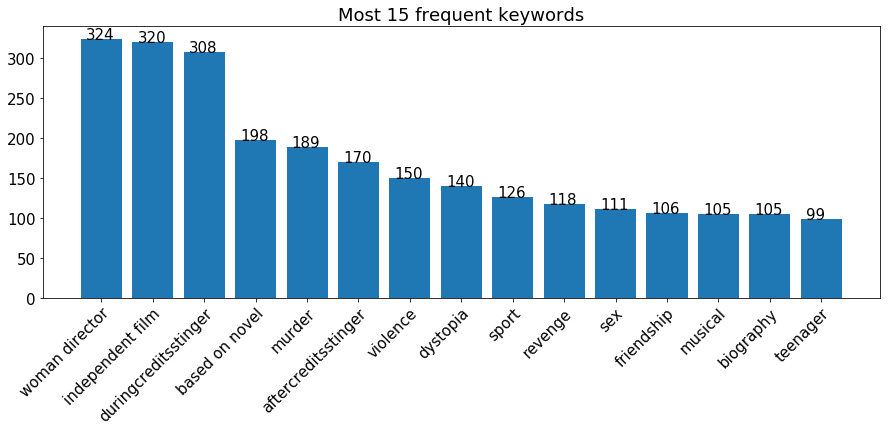

In [18]:
how_much_keywords = 15
column = "keywords"

most_freq_items(how_much_keywords, column)

We can see that some words are very frequent in keywords . Woman director is most used keyword, and having in mind that we have nearly 4800 movies, the women director shows up as keyword in nearly 7% of movies

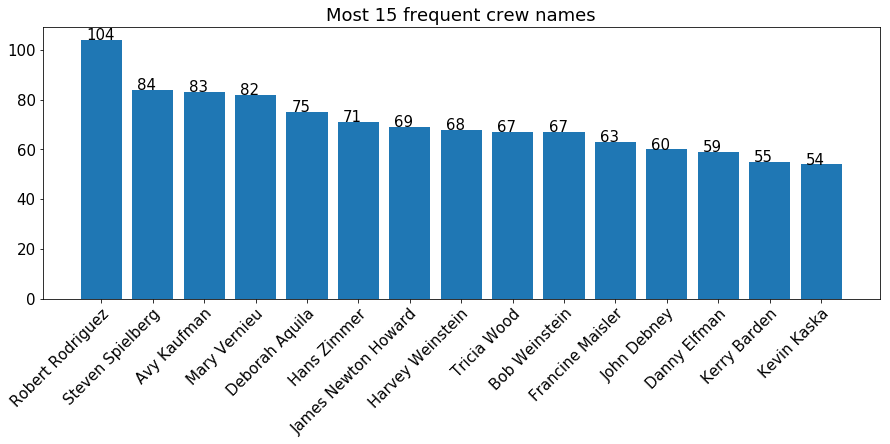

In [19]:
how_much_crew = 15
column = "crew_names"

most_freq_items(how_much_crew, column)

Here are shown the most frequent 15 crew names. Most working crew member is Robert Rodriguez with more than 100 movies, and the next member has been in nealry 80 movies. After these names, the number of different crew's movies slowly decrease form 80 to 60

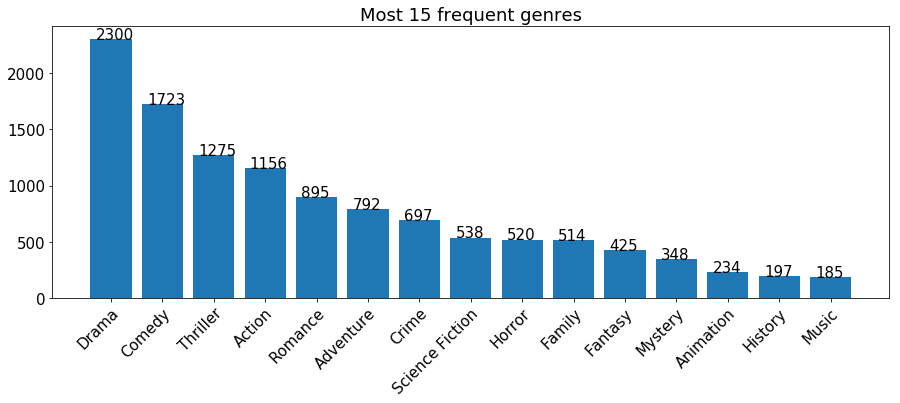

In [20]:
how_much_genre = 15
column = "genres"

most_freq_items(how_much_genre, column)

Drama, Comedy and Thriller are most frequent genres. It seems like more than 40% movies has drama in its genre description.

## Data Expoitation and Evaluation

In [52]:
Movies['actors']               = Movies['actors'].apply(lambda x: x.replace(" ", "_"))
Movies['keywords']             = Movies['keywords'].apply(lambda x: x.replace(" ", "_"))
Movies['crew_names']           = Movies['crew_names'].apply(lambda x: x.replace(" ", "_"))
Movies['production_companies'] = Movies['production_companies'].apply(lambda x: x.replace(" ", "_"))
#from multiprocessing import Pool
import multiprocessing
from multiprocessing import Pool, cpu_count
import functools

##warning global viariables in use
Entries = 'blah'

def GetSingleEntryFrame(Comparator):
    def Transformer(Entrys):
        for Entry in Entrys.split(","):
            if Entry==Comparator:
                return 1
        return 0
    SingleEntryFrame = pd.DataFrame()
    SingleEntryFrame[Comparator]          = Movies[Entries].apply(Transformer)
    Treshold = 2
    if Entries == 'keywords' or Entries == 'production_companies':
        Treshold == 2
    if SingleEntryFrame[Comparator].sum() <Treshold:
        return pd.DataFrame()
    return SingleEntryFrame

def join_dfs(ldf, rdf):
    return ldf.join(rdf, how='inner')

def applyParallel(df, func):
    multiprocessing
    with Pool(cpu_count()) as p:  
        ret_list = p.map(func, [Comparator for Comparator in GetEntryList()])
     
    print("Merging Started")
    Unified = pd.DataFrame()
    for df in ret_list:
        Unified[df.columns] = df[df.columns]
    return Unified

def GetEntryList():
    AllEntrys=""
    for Entrys in Movies[Entries]:
        AllEntrys+=Entrys
    EntryList =list(set(AllEntrys.split(",")))
    return EntryList

def TransformEntrys(Movies):
    EntrysFrame = applyParallel(Movies,GetSingleEntryFrame)
    return EntrysFrame 

def ProcessCategorical(feature):
    global Entries 
    Entries = feature
    Frame=TransformEntrys(Movies)
    Frame.to_csv("../Datasets/"+str(feature)+".csv")
    print(Frame) 
    return Frame

Frames = []
for feature in ['prime_actors','prime_keywords','prime_crew_names','primary_production_company']:
    Frames.append(ProcessCategorical(feature).fillna(0))
     
    
print("DONE")

Merging Started
                                           Maggie Grace  Chiwetel Ejiofor  \
title                                                                       
#Horror                                               0                 0   
(500) Days of Summer                                  0                 0   
10 Cloverfield Lane                                   0                 0   
10 Days in a Madhouse                                 0                 0   
10 Things I Hate About You                            0                 0   
102 Dalmatians                                        0                 0   
10th & Wolf                                           0                 0   
11:14                                                 0                 0   
12 Angry Men                                          0                 0   
12 Rounds                                             0                 0   
12 Years a Slave                                      0     

Merging Started
                                           guantanamo bay  champion  \
title                                                                 
#Horror                                                 0         0   
(500) Days of Summer                                    0         0   
10 Cloverfield Lane                                     0         0   
10 Days in a Madhouse                                   0         0   
10 Things I Hate About You                              0         0   
102 Dalmatians                                          0         0   
10th & Wolf                                             0         0   
11:14                                                   0         0   
12 Angry Men                                            0         0   
12 Rounds                                               0         0   
12 Years a Slave                                        0         0   
127 Hours                                               0    

Merging Started
                                           Gore Verbinski  Theodore Shapiro  \
title                                                                         
#Horror                                                 0                 0   
(500) Days of Summer                                    0                 0   
10 Cloverfield Lane                                     0                 0   
10 Days in a Madhouse                                   0                 0   
10 Things I Hate About You                              0                 0   
102 Dalmatians                                          0                 0   
10th & Wolf                                             0                 0   
11:14                                                   0                 0   
12 Angry Men                                            0                 0   
12 Rounds                                               0                 0   
12 Years a Slave                    

Merging Started
Empty DataFrame
Columns: []
Index: []
DONE


In [53]:
all_distances=[]
for Frame in Frames:
    all_distances.append(scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Frame, metric='cosine') ))
 

In [54]:
GrandFinal = pd.DataFrame()
for col in ['budget', 'popularity', 'runtime', 'vote_average','vote_count']:
    GrandFinal[col]      = Movies[col] 
Grand_distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(GrandFinal, metric='cosine'))

In [55]:
GrandFinal.to_csv("../Datasets/GrandFinalle.csv") 

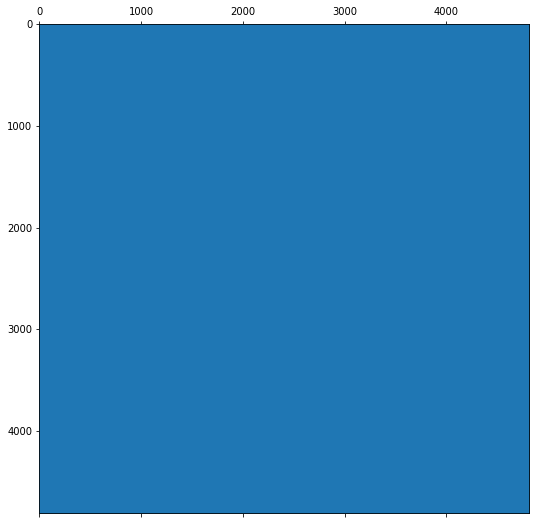

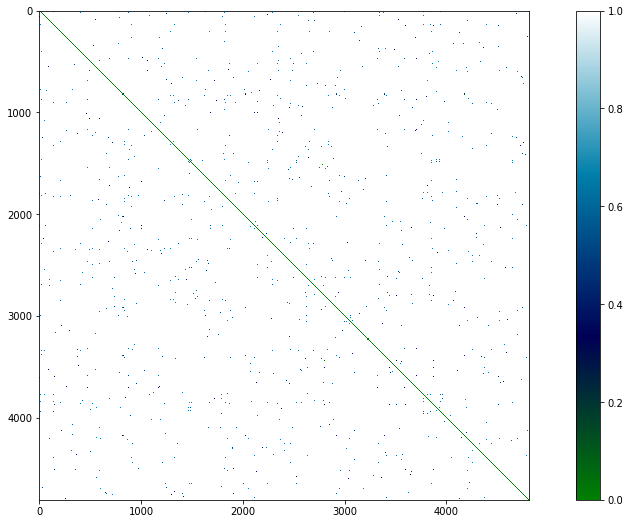

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(all_distances[0], interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

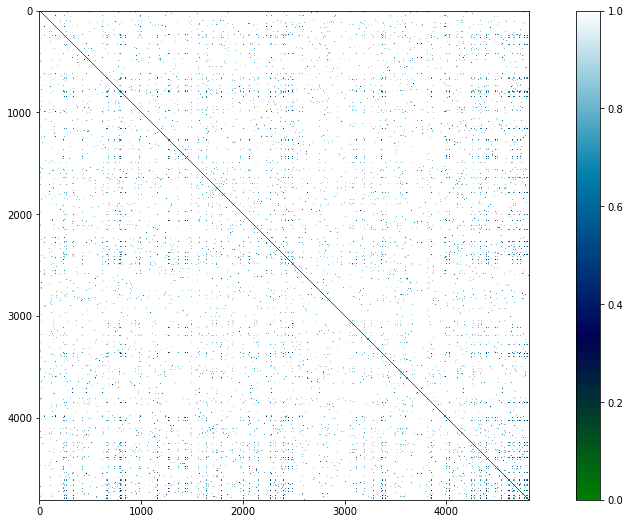

In [57]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(all_distances[1], interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

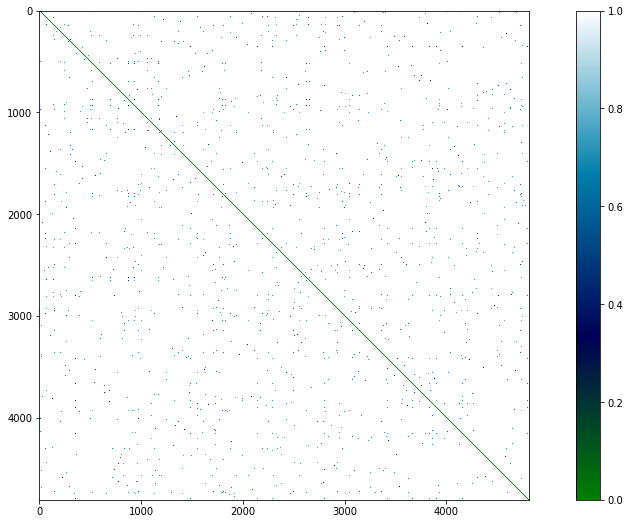

In [58]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(all_distances[2], interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [59]:
CatDistances = all_distances[0] + all_distances[1] + all_distances[2]

In [60]:
plt.rcParams['figure.figsize'] = (17, 9)

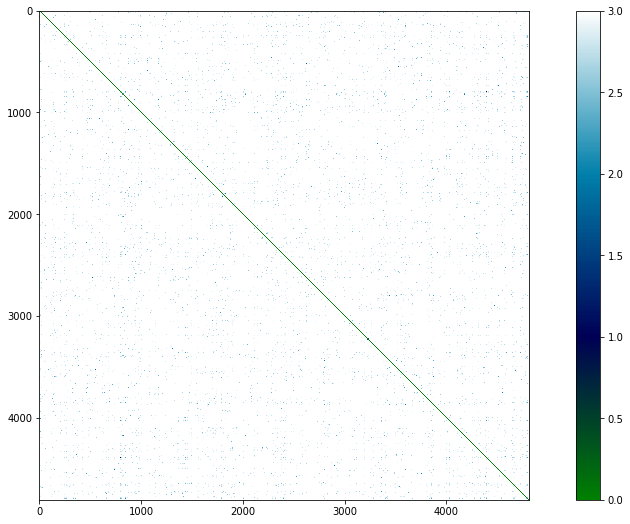

In [61]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(CatDistances, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [62]:
plt.spy(CatDistances, markersize = 1)

/home/Programs/Anaconda/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7326: RuntimeWarning: invalid value encountered in greater
  nonzero = np.abs(Z) > precision


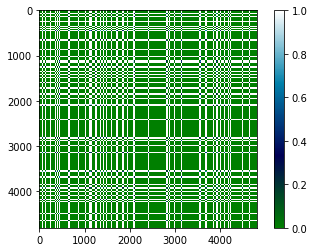

In [33]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(Grand_distances, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

In [60]:
GrandFinal = GrandFinal.fillna(0)
features_pca = decomposition.PCA(n_components=100).fit_transform(GrandFinal)

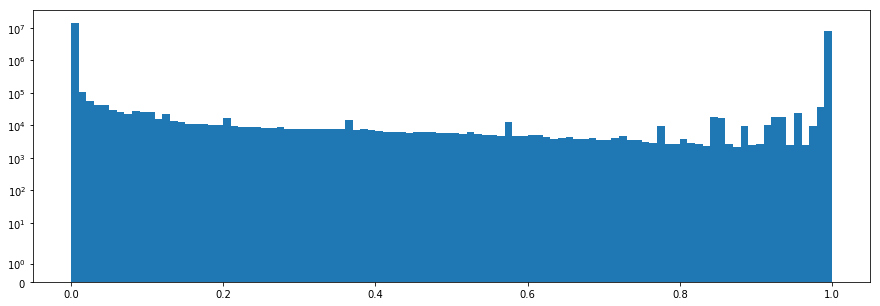

In [63]:
%matplotlib inline
fig, axes = plt.subplots(figsize=(15, 5))

# Budget is plotted in log scale on y axis
axes.set(yscale="symlog")
plt.hist(distances.reshape(-1), bins=100);

In [64]:
kernel_width = distances.mean()
print(kernel_width)
#getting the weights using given kernel
weights = np.zeros((len(distances),len(distances)))
for i in range(0, len(distances)):
    for j in range(0,len(distances)):
        weights[i][j]=  np.exp((-distances[i][j]*distances[i][j])/(kernel_width*kernel_width))

        
        
#weights = np.asarray([[ np.exp(-(d**2)/(kernel_width**2)) for d in line] for line in distances]) #?


#setting diagonal terms to zeros
np.fill_diagonal(weights, 0)

0.354057043938


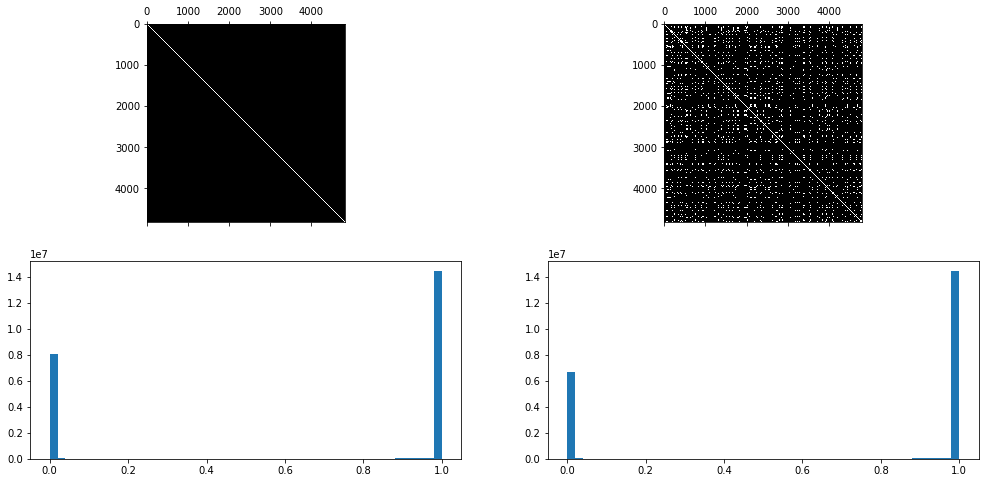

In [65]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 4000

newweights = np.zeros((4809,4809))

#dropping edges while keeping only 100 strongest
#dropping per edge side to avoid disconected nodes
counter=0
for line in weights:
    ordered_indices = np.argsort(line)[len(line)-NEIGHBORS:]#[:len(line)-NEIGHBORS]
    for i in ordered_indices:
        newweights[counter][i] = line[i]
        newweights[i][counter] = line[i]
        line[i]=0
    counter+=1    

weights = newweights
#symetrizing weights matrix, needed due to case when 
#edge between nodes A and B is in 100 strongest edges of A but not in 100 stronges edges of B
bigger = weights.transpose() > weights
weights = weights - weights*bigger + weights.transpose()*bigger
       

plot(weights, axes[:, 1])

In [66]:
distances =scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(features_pca, metric='cosine') )

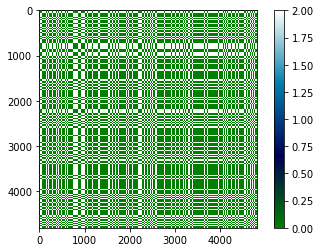

In [67]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.set_aspect('equal')
plt.imshow(distances, interpolation='nearest', cmap=plt.cm.ocean)
plt.colorbar()
plt.show()

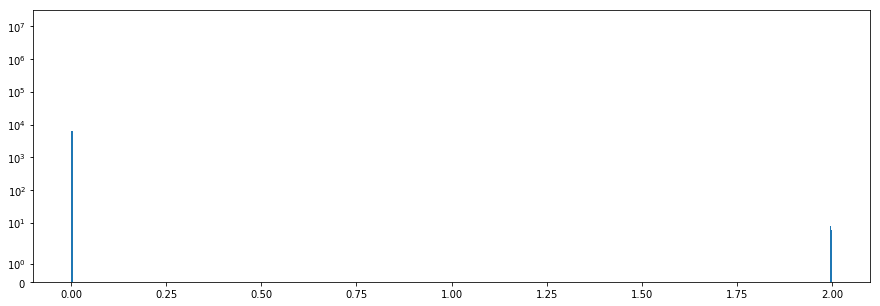

In [70]:
fig, axes = plt.subplots(figsize=(15, 5))

# Budget is plotted in log scale on y axis
axes.set(yscale="symlog")
plt.hist(distances.reshape(-1), bins=10000);

In [ ]:
## first part / milestones 3 & 4

In [10]:
## edited text from proposal

Since many movie attributes are not numerical, it is necessary to calculate overlap matrix for each movie attribute separately using a feature-specific overlap calculating function. Generated series of overlap matrices will be combined into one single weight matrix. However, the choice of combining method is arbitrary. Therefore, several examples of combining method are considered. 

In [ ]:
## second part / milestones 5 & 6

In [ ]:
## edited text from proposal

Once the graph is created, e.g. the weight matrix is established, it will be sparced using k-nearest neighbors and Laplacian matrix and its corresponding eigendecomposition will be calculated. The constructed graph is visualized using PCA and using Laplacian eigendecomposition in order to observe clusters of similarity in terms of genres, popularity etc. Furthermore, studying connectivity of the graph and degrees of nodes it is possible to estimate how
mainstream a movie is. Also, a study of choice of a category representative may be conducted choosing a movie which represents the cluster in the best way. For example, if k-nearest neighbors method is utilized with k equal to 1, we can obtain disconnected graph with clusters of movies, and the node to which the most of the edges oriented  point, is appointed as a category representative. Using a category representative allows a viewer to get an impression on entire category based on watching only a single movie.

In [8]:
#
Movies.reduce()

AttributeError: 'DataFrame' object has no attribute 'reduce'

## Conclusion

In [ ]:
# Your code here.
genres = preprocessing.LabelEncoder().fit_transform(tracks['genre'])

holder = []
Weights=weights[:]
for i in range(0,len(Weights)):
    if genres[i]==1:
        holder.append(Weights[i])
    else:
        holder.insert(0, Weights[i])
        
WEIGHTS = []
holder=np.asarray(holder).T
for i in range(0,len(holder)):
    if genres[i]==1:
        WEIGHTS.append(holder[i])
    else:
        WEIGHTS.insert(0, holder[i])

plt.spy(WEIGHTS, markersize=1)